# Basic semantic segmentation using average unpooling

In [7]:
from PIL import Image
# import cPickle as pkl
import time
import numpy as np
import matplotlib.pyplot as plt
# from tensorflow.python.training import moving_averages
# import tensorflow as tf
import tensorflow.compat.v1 as tf
from tensorflow.python.training import moving_averages
import glob
import os
tf.disable_eager_execution()
%matplotlib inline  
print ("Packs loaded.")

Packs loaded.


# Load dataset for semantic segmentation

In [8]:
# Location of the files
camvidpath = '../../SegNet-Tutorial/CamVid/'
# Training data
path1 = os.getcwd() + '/' + camvidpath + 'train/'
path2 = os.getcwd() + '/' + camvidpath + 'trainannot/'
trainimglist = glob.glob(path1 + '/*.png')
trainannotlist = glob.glob(path2 + '/*.png')
print ("%d train images" % (len(trainimglist)))
print ("%d train annotations" % (len(trainannotlist)))

# Test data
path1 = os.getcwd() + '/' + camvidpath + 'test/'
path2 = os.getcwd() + '/' + camvidpath + 'testannot/'
testimglist = glob.glob(path1 + '/*.png')
testannotlist = glob.glob(path2 + '/*.png')
print ("%d test images" % (len(testimglist)))
print ("%d test annotations" % (len(testannotlist)))

367 train images
367 train annotations
233 test images
233 test annotations


# Get train / test images

In [28]:
height = 128
width = 128
nrclass = 22
trainData = None
trainLabel = None
trainLabelOneHot = None
trainlen = len(trainimglist)
testData = None
testLabel = None
testLabelOneHot = None
testlen = len(testimglist)
def DenseToOneHot(labels_dense, num_classes):
    # Convert class labels from scalars to one-hot vectors. 
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot
""" Train data process """ 
for (f1, f2, i) in zip(trainimglist, trainannotlist, range(trainlen)):
    # print ("[%02d/%02d]f1: %sf2: %s" % (i, trainlen, f1, f2))
    # Train image
    img1 = Image.open(f1)
    img1 = img1.resize((height, width))
    rgb  = np.array(img1).reshape(1, height, width, 3)
    # Train label
    img2 = Image.open(f2)
    img2 = img2.resize((height, width), Image.NEAREST)
    label = np.array(img2).reshape(1, height, width, 1)
    # Stack images and labels
    if i == 0: 
        trainData = rgb
        trainLabel = label
    else:
        trainData = np.concatenate((trainData, rgb), axis=0)
        trainLabel = np.concatenate((trainLabel, label), axis=0)
ntrain = len(trainData)
# Onehot-coded label
trainLabelOneHot = np.zeros((trainLabel.shape[0], trainLabel.shape[1]                             , trainLabel.shape[2], nrclass))
for row in range(height):
    for col in range(width):
        single = trainLabel[:, row, col, 0]
        oneHot = DenseToOneHot(single, nrclass) # (367,) => (367, 22)
        trainLabelOneHot[:, row, col, :] = oneHot
print ("Train data process done.")     

""" Test data process """ 
for (f1, f2, i) in zip(testimglist, testannotlist, range(testlen)):
    # print ("[%02d/%02d]f1: %sf2: %s" % (i, testlen, f1, f2))
    # Train image
    img1 = Image.open(f1)
    img1 = img1.resize((height, width))
    rgb  = np.array(img1).reshape(1, height, width, 3)
    # Train label
    img2 = Image.open(f2)
    img2 = img2.resize((height, width), Image.NEAREST)
    label = np.array(img2).reshape(1, height, width, 1)
    # Stack images and labels
    if i == 0: 
        testData = rgb
        testLabel = label
    else:
        testData = np.concatenate((testData, rgb), axis=0)
        testLabel = np.concatenate((testLabel, label), axis=0)
ntest = len(testData)
# Onehot-coded label
testLabelOneHot = np.zeros((testLabel.shape[0], testLabel.shape[1], testLabel.shape[2], nrclass))
for row in range(height):
    for col in range(width):
        single = testLabel[:, row, col, 0]
        oneHot = DenseToOneHot(single, nrclass) # (367,) => (367, 22)
        testLabelOneHot[:, row, col, :] = oneHot
print ("Test data process done.")

Train data process done.
Test data process done.


In [10]:
print ("Shape of 'trainData' is %s" % (trainData.shape,))
print ("Shape of 'trainLabel' is %s" % (trainLabel.shape,))
print ("Shape of 'trainLabelOneHot' is %s" % (trainLabelOneHot.shape,))
print ("Shape of 'testData' is %s" % (testData.shape,))
print ("Shape of 'testLabel' is %s" % (testLabel.shape,))
print ("Shape of 'testLabelOneHot' is %s" % (testLabelOneHot.shape,))

Shape of 'trainData' is (367, 128, 128, 3)
Shape of 'trainLabel' is (367, 128, 128, 1)
Shape of 'trainLabelOneHot' is (367, 128, 128, 22)
Shape of 'testData' is (233, 128, 128, 3)
Shape of 'testLabel' is (233, 128, 128, 1)
Shape of 'testLabelOneHot' is (233, 128, 128, 22)


# Define networks

In [11]:
# Define functions
x = tf.placeholder(tf.float32, [None, height, width, 3])
y = tf.placeholder(tf.float32, [None, height, width, nrclass])
keepprob = tf.placeholder(tf.float32)
# Kernels
ksize = 5
fsize = 64
initstdev = 0.01
initfun = tf.random_normal_initializer(mean=0.0, stddev=initstdev)
# initfun = None
weights = {
    'ce1': tf.get_variable("ce1", shape = [ksize, ksize, 3, fsize], initializer = initfun) ,
    'ce2': tf.get_variable("ce2", shape = [ksize, ksize, fsize, fsize], initializer = initfun) ,
    'ce3': tf.get_variable("ce3", shape = [ksize, ksize, fsize, fsize], initializer = initfun),
    'ce4': tf.get_variable("ce4", shape = [ksize, ksize, fsize, fsize], initializer = initfun),
    'cd4': tf.get_variable("cd4", shape = [ksize, ksize, fsize, fsize], initializer = initfun),
    'cd3': tf.get_variable("cd3", shape = [ksize, ksize, fsize, fsize], initializer = initfun),
    'cd2': tf.get_variable("cd2", shape = [ksize, ksize, fsize, fsize], initializer = initfun),
    'cd1': tf.get_variable("cd1", shape = [ksize, ksize, fsize, fsize], initializer = initfun),
    'dense_inner_prod': tf.get_variable("dense_inner_prod", shape= [1, 1, fsize, nrclass]
                                       , initializer = initfun) # <= 1x1conv
}
biases = {
    'be1': tf.get_variable("be1", shape = [fsize], initializer = tf.constant_initializer(value=0.0)),
    'be2': tf.get_variable("be2", shape = [fsize], initializer = tf.constant_initializer(value=0.0)),
    'be3': tf.get_variable("be3", shape = [fsize], initializer = tf.constant_initializer(value=0.0)),
    'be4': tf.get_variable("be4", shape = [fsize], initializer = tf.constant_initializer(value=0.0)),
    'bd4': tf.get_variable("bd4", shape = [fsize], initializer = tf.constant_initializer(value=0.0)),
    'bd3': tf.get_variable("bd3", shape = [fsize], initializer = tf.constant_initializer(value=0.0)),
    'bd2': tf.get_variable("bd2", shape = [fsize], initializer = tf.constant_initializer(value=0.0)),
    'bd1': tf.get_variable("bd1", shape = [fsize], initializer = tf.constant_initializer(value=0.0))
}

# DeconvNet model

In [21]:
# input : [m, h, w, c]
def Unpooling(inputOrg, size, mask=None):
    # m, c, h, w order
    m = size[0]
    h = size[1]
    w = size[2]
    c = size[3]
    input = tf.transpose(inputOrg, [0, 3, 1, 2])
    x = tf.reshape(input, [-1, 1])
    k = np.float32(np.array([1.0, 1.0]).reshape([1,-1]))
    output = tf.matmul(x, k)
    output = tf.reshape(output,[-1, c, h, w * 2])
    # m, c, w, h
    xx = tf.transpose(output, [0, 1, 3, 2])
    xx = tf.reshape(xx,[-1, 1])
    output = tf.matmul(xx, k)
    # m, c, w, h
    output = tf.reshape(output, [-1, c, w * 2, h * 2])
    output = tf.transpose(output, [0, 3, 2, 1])
    outshape = tf.stack([m, h * 2, w * 2, c])
    if mask != None:
        dense_mask = tf.sparse_to_dense(mask, outshape, output, 0)
        return output, dense_mask
    else:
        return output

# DeconvNet Model
def Model(_X, _W, _b, _keepprob):
    use_bias = 1
    # Encoder 128x128
    encoder1 = tf.nn.conv2d(_X, _W['ce1'], strides=[1, 1, 1, 1], padding='SAME')
    if use_bias:
        encoder1 = tf.nn.bias_add(encoder1, _b['be1'])
    mean, var = tf.nn.moments(encoder1, [0, 1, 2])
    encoder1 = tf.nn.batch_normalization(encoder1, mean, var, 0, 1, 0.0001)
    encoder1 = tf.nn.relu(encoder1)
    encoder1 = tf.nn.max_pool(encoder1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    encoder1 = tf.nn.dropout(encoder1, _keepprob)
    # 64x64
    encoder2 = tf.nn.conv2d(encoder1, _W['ce2'], strides=[1, 1, 1, 1], padding='SAME')
    if use_bias:
        encoder2 = tf.nn.bias_add(encoder2, _b['be2'])
    mean, var = tf.nn.moments(encoder1, [0, 1, 2])
    encoder2 = tf.nn.batch_normalization(encoder2, mean, var, 0, 1, 0.0001)
    encoder2 = tf.nn.relu(encoder2)
    encoder2 = tf.nn.max_pool(encoder2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    encoder2 = tf.nn.dropout(encoder2, _keepprob)
    # 32x32
    encoder3 = tf.nn.conv2d(encoder2, _W['ce3'], strides=[1, 1, 1, 1], padding='SAME')
    if use_bias:
        encoder3 = tf.nn.bias_add(encoder3, _b['be3'])
    mean, var = tf.nn.moments(encoder3, [0, 1, 2])
    encoder3 = tf.nn.batch_normalization(encoder3, mean, var, 0, 1, 0.0001)
    encoder3 = tf.nn.relu(encoder3)
    encoder3 = tf.nn.max_pool(encoder3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    encoder3 = tf.nn.dropout(encoder3, _keepprob)
    # 16x16
    encoder4 = tf.nn.conv2d(encoder3, _W['ce4'], strides=[1, 1, 1, 1], padding='SAME')
    if use_bias:
        encoder4 = tf.nn.bias_add(encoder4, _b['be4'])
    mean, var = tf.nn.moments(encoder4, [0, 1, 2])
    encoder4 = tf.nn.batch_normalization(encoder4, mean, var, 0, 1, 0.0001)
    encoder4 = tf.nn.relu(encoder4)
    encoder4 = tf.nn.max_pool(encoder4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    encoder4 = tf.nn.dropout(encoder4, _keepprob)
    # 8x8

    # Decoder 8x8 (128/16 = 8) fsize: 64
    decoder4 = Unpooling(encoder4, [tf.shape(_X)[0], int(height / 16), int(width / 16), fsize])
    decoder4 = tf.nn.conv2d_transpose(decoder4, _W['cd4']
                , tf.stack([tf.shape(_X)[0], ksize, ksize, fsize])
                , strides=[1, 1, 1, 1], padding='SAME')
    if use_bias:
        decoder4 = tf.nn.bias_add(decoder4, _b['bd4'])
    mean, var = tf.nn.moments(decoder4, [0, 1, 2])
    decoder4 = tf.nn.batch_normalization(decoder4, mean, var, 0, 1, 0.0001)
    decoder4 = tf.nn.relu(decoder4)
    decoder4 = tf.nn.dropout(decoder4, _keepprob)
    # 16x16
    decoder3 = Unpooling(encoder3, [tf.shape(_X)[0], int(height/8), int(width/8), fsize])
    decoder3 = tf.nn.conv2d(decoder3, _W['cd3'], strides=[1, 1, 1, 1], padding='SAME')
    
    if use_bias:
        decoder3 = tf.nn.bias_add(decoder3, _b['bd3'])
    mean, var = tf.nn.moments(decoder3, [0, 1, 2])
    decoder3 = tf.nn.batch_normalization(decoder3, mean, var, 0, 1, 0.0001)
    decoder3 = tf.nn.relu(decoder3)
    decoder3 = tf.nn.dropout(decoder3, _keepprob)
    # 32x32
    decoder2 = Unpooling(decoder3, [tf.shape(_X)[0], int(height/4), int(width/4), fsize])
    decoder2 = tf.nn.conv2d(decoder2, _W['cd2'], strides=[1, 1, 1, 1], padding='SAME')
    if use_bias:
        decoder2 = tf.nn.bias_add(decoder2, _b['bd2'])
    mean, var = tf.nn.moments(decoder2, [0, 1, 2])
    decoder2 = tf.nn.batch_normalization(decoder2, mean, var, 0, 1, 0.0001)
    decoder2 = tf.nn.relu(decoder2)
    decoder2 = tf.nn.dropout(decoder2, _keepprob)
    # 64x64
    decoder1 = Unpooling(decoder2, [tf.shape(_X)[0], int(height / 2), int(width / 2), fsize])
    decoder1 = tf.nn.conv2d(decoder1, _W['cd1'], strides=[1, 1, 1, 1], padding='SAME')
    if use_bias:
        decoder1 = tf.nn.bias_add(decoder1, _b['bd1'])
    mean, var = tf.nn.moments(decoder1, [0, 1, 2])
    decoder1 = tf.nn.batch_normalization(decoder1, mean, var, 0, 1, 0.0001)
    decoder1 = tf.nn.relu(decoder1)
    decoder1 = tf.nn.dropout(decoder1, _keepprob)
    # 128x128
    output = tf.nn.conv2d(decoder1, _W['dense_inner_prod'], strides=[1, 1, 1, 1], padding='SAME')
    return output

print ("Network ready")

Network ready


In [22]:
ksize

5

# Define functions

In [36]:
pred = Model(x, weights, biases, keepprob)
lin_pred = tf.reshape(pred, shape=[-1, nrclass])
lin_y = tf.reshape(y, shape=[-1, nrclass])
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = lin_pred, labels = lin_y))
# Class label
predmax = tf.argmax(pred, 3)
ymax = tf.argmax(y, 3)
# Accuracy
corr = tf.equal(tf.argmax(y,3), tf.argmax(pred, 3)) 
accr = tf.reduce_mean(tf.cast(corr, "float"))
# Optimizer
optm = tf.train.AdamOptimizer(0.0001).minimize(cost)
batch_size = 32
n_epochs = 1000

print ("Functions ready")

Functions ready


In [37]:
ntest,ntrain

(233, 367)

# Real optimization starts here

checkpoint: None
Couldn't find checkpoint to restore from. Starting over.
[00/1000] trainLoss: 2.9880 trainAcc: 0.47 valLoss: 0.1021 valAcc: 0.01


<ipython-input-38-fe9d6873651d>:70: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.subplot(2, 2, 2); plt.pcolor(xs, ys, gtimg, vmin=0, vmax=nrclass); plt.title('Ground truth')
<ipython-input-38-fe9d6873651d>:71: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.subplot(2, 2, 3); plt.pcolor(xs, ys, predMaxOut[0, :, :].reshape(height, width), vmin=0, vmax=nrclass); plt.title('[Training] Prediction')


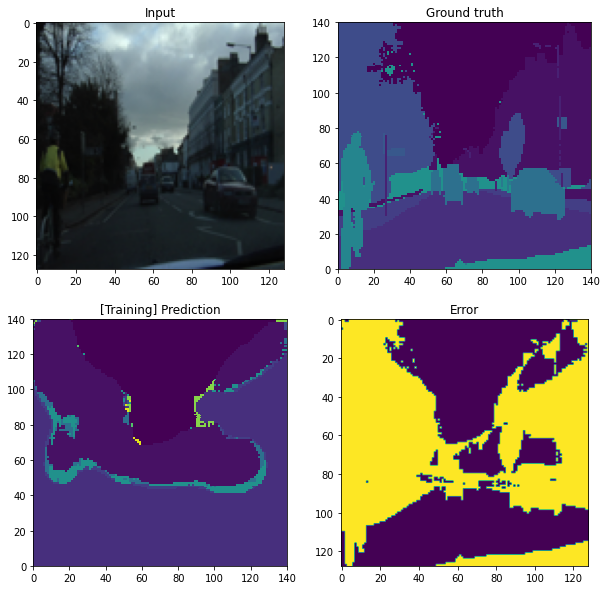

<ipython-input-38-fe9d6873651d>:86: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.subplot(2, 2, 2); plt.pcolor(xs, ys, gtimg, vmin=0, vmax=nrclass);  plt.title('Ground truth')
<ipython-input-38-fe9d6873651d>:87: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.subplot(2, 2, 3); plt.pcolor(xs, ys, predMaxOut[0, :, :].reshape(height, width), vmin=0, vmax=nrclass); plt.title('[Validation] Prediction')


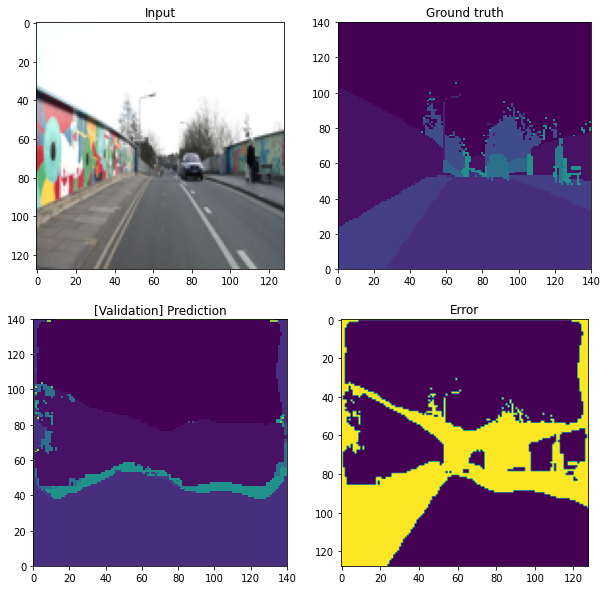

[01/1000] trainLoss: 2.8879 trainAcc: 0.62 valLoss: 0.0992 valAcc: 0.02
[02/1000] trainLoss: 2.8165 trainAcc: 0.65 valLoss: 0.0973 valAcc: 0.02
[03/1000] trainLoss: 2.7521 trainAcc: 0.67 valLoss: 0.0955 valAcc: 0.02
[04/1000] trainLoss: 2.6940 trainAcc: 0.67 valLoss: 0.0935 valAcc: 0.02
[05/1000] trainLoss: 2.6327 trainAcc: 0.68 valLoss: 0.0923 valAcc: 0.02
[06/1000] trainLoss: 2.5772 trainAcc: 0.68 valLoss: 0.0906 valAcc: 0.02
[07/1000] trainLoss: 2.5192 trainAcc: 0.69 valLoss: 0.0892 valAcc: 0.02
[08/1000] trainLoss: 2.4637 trainAcc: 0.70 valLoss: 0.0868 valAcc: 0.02
[09/1000] trainLoss: 2.4122 trainAcc: 0.69 valLoss: 0.0853 valAcc: 0.02
[10/1000] trainLoss: 2.3570 trainAcc: 0.70 valLoss: 0.0838 valAcc: 0.02


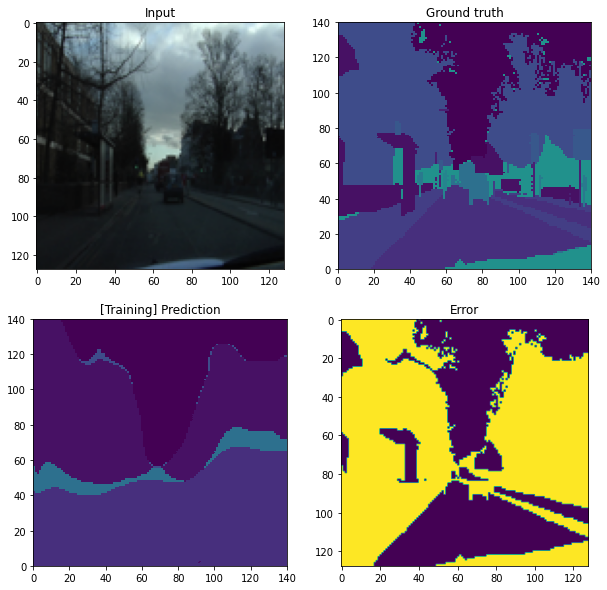

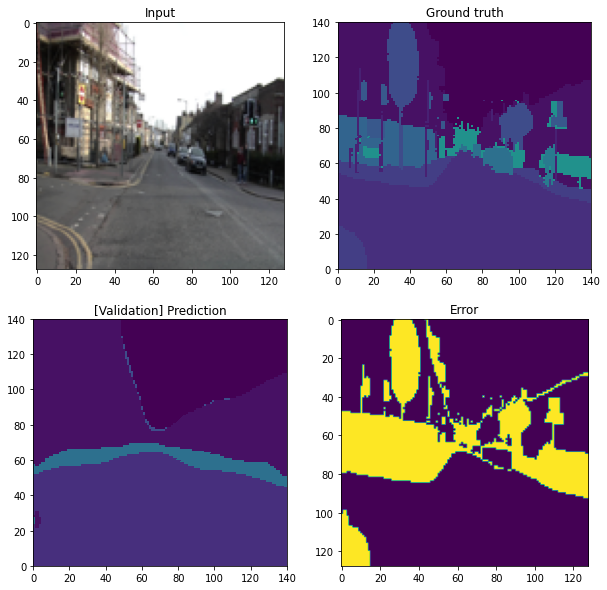

[11/1000] trainLoss: 2.3070 trainAcc: 0.70 valLoss: 0.0821 valAcc: 0.02


KeyboardInterrupt: 

In [38]:
resumeTraining = True
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
config.allow_soft_placement=True


with tf.Session(config=config) as sess:
    # you need to initialize all variables
    tf.global_variables_initializer().run()
    saver = tf.train.Saver()
    checkpoint = tf.train.latest_checkpoint("nets/semseg_basic")
    print ("checkpoint: %s" % (checkpoint))
    if resumeTraining == False:
        print("Start from scratch")
    elif  checkpoint:
        print("Restoring from checkpoint", checkpoint)
        saver.restore(sess, checkpoint)
    else:
        print("Couldn't find checkpoint to restore from. Starting over.")
    
    for epoch_i in range(n_epochs):
        trainLoss = []; trainAcc = []
        num_batch = int(ntrain/batch_size)+1
        for _ in range(num_batch):
            randidx = np.random.randint(ntrain, size=batch_size)
            batchData = trainData[randidx]
            batchLabel = trainLabelOneHot[randidx]
            sess.run(optm, feed_dict={x: batchData, y: batchLabel, keepprob: 0.7}) # <== Optm is done here!
            trainLoss.append(sess.run(cost, feed_dict={x: batchData, y: batchLabel, keepprob: 1.}))
            trainAcc.append(sess.run(accr, feed_dict={x: batchData, y: batchLabel, keepprob: 1.}))
        # Average loss and accuracy
        trainLoss = np.mean(trainLoss)
        trainAcc = np.mean(trainAcc)
        # Run test
        
        num_batch = int(ntest/batch_size)+1        
        for i in range(num_batch):
            startIndex = i*num_batch
            endIndex = (i+1)*num_batch
            if endIndex> ntest:
                endIndex = ntest
            weight = (endIndex-startIndex)/ntest
            batchData = testData[startIndex:endIndex]
            batchLabel = testLabelOneHot[startIndex:endIndex]
            
            valLoss=sess.run(cost, feed_dict={x: batchData, y: batchLabel, keepprob: 1.})*weight
            valAcc=sess.run(accr, feed_dict={x: batchData, y: batchLabel, keepprob: 1.})*weight
          

        print ("[%02d/%02d] trainLoss: %.4f trainAcc: %.2f valLoss: %.4f valAcc: %.2f" 
               % (epoch_i, n_epochs, trainLoss, trainAcc, valLoss, valAcc))
        # Save snapshot
        if resumeTraining and epoch_i % 10 == 0:
            # Save
            saver.save(sess, 'nets/semseg_basic/progress', global_step = epoch_i)
            # Train data
            index = np.random.randint(trainData.shape[0])
            refimg = trainData[index, :, :, :].reshape(height, width, 3)
            batchData = trainData[index:index+1]
            batchLabel = trainLabelOneHot[index:index+1]
            predMaxOut = sess.run(predmax, feed_dict={x: batchData, y: batchLabel, keepprob:1.})
            yMaxOut = sess.run(ymax, feed_dict={x: batchData, y: batchLabel, keepprob:1.})
            gtimg = yMaxOut[0, :, :].reshape(height, width)
            errimg = gtimg - predMaxOut[0, :, :].reshape(height, width);
            # Plot
            xs = np.linspace(0, 140, 128); ys = np.linspace(140, 0, 128)
            plt.figure(figsize=(10, 10)) 
            plt.subplot(2, 2, 1); plt.imshow(refimg); plt.title('Input')
            plt.subplot(2, 2, 2); plt.pcolor(xs, ys, gtimg, vmin=0, vmax=nrclass); plt.title('Ground truth')
            plt.subplot(2, 2, 3); plt.pcolor(xs, ys, predMaxOut[0, :, :].reshape(height, width), vmin=0, vmax=nrclass); plt.title('[Training] Prediction')
            plt.subplot(2, 2, 4); plt.imshow(np.abs(errimg) > 0.5); plt.title('Error')
            plt.show() 
            # Test data
            index = np.random.randint(testData.shape[0])
            batchData = testData[index:index+1]
            batchLabel = testLabelOneHot[index:index+1]
            predMaxOut = sess.run(predmax, feed_dict={x: batchData, y: batchLabel, keepprob:1.})
            yMaxOut = sess.run(ymax, feed_dict={x: batchData, y: batchLabel, keepprob:1.})
            refimg = testData[index, :, :, :].reshape(height, width, 3)
            gtimg = yMaxOut[0, :, :].reshape(height, width)
            errimg = gtimg - predMaxOut[0, :, :].reshape(height, width)
            # Plot
            plt.figure(figsize=(10, 10)) 
            plt.subplot(2, 2, 1); plt.imshow(refimg); plt.title('Input')
            plt.subplot(2, 2, 2); plt.pcolor(xs, ys, gtimg, vmin=0, vmax=nrclass);  plt.title('Ground truth')
            plt.subplot(2, 2, 3); plt.pcolor(xs, ys, predMaxOut[0, :, :].reshape(height, width), vmin=0, vmax=nrclass); plt.title('[Validation] Prediction')
            plt.subplot(2, 2, 4); plt.imshow(np.abs(errimg) > 0.5); plt.title('Error')
            plt.show()

print ("Done")